# K-Means Clustering: Google Play Store Apps Analysis

## Business Use Case

The Objective of this exercise is to analyze the 10,000 Play Store apps and understand underlying relationships.  By creating clusters for these apps, we will look at the 13 available variables, determine which are important via means like principal component analysis (PCA), and provide the ability to dive further into individual clusters (listing which apps are in a given cluster).  Lastly, we'll provide next steps to take this analysis further.

## Imports and Setup

In [727]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import codecs
import matplotlib.colors

from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.cluster import KMeans
from pylab import rcParams

#Format and Standardize Matplotlib
#Used for graphs/charts inside Jupyter
%matplotlib inline 
#Used for interactive graphs/charts outside Jupyter, including 3d model rotations
#%matplotlib qt 
rcParams['figure.figsize'] = 20,16
sb.set_style('whitegrid')

## Data Wrangling and Transformation

### Data Ingestion

We start off, by reading our csv file and looking at the first 5 records.

In [728]:
#Get the data and create a pandas dataframe
location = "C:/Users/B/Downloads/google-play-store-apps/googleplaystore.csv"
df=pd.read_csv(location)
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In this case, the apps do not have characters that require specific encoding instructions.  If there were special characters, codecs provides an easy solution for this, with the sample code listed below:

In [729]:
with codecs.open(location, "r", encoding='utf-8', errors='ignore') as dataUTF:
    df = pd.read_csv(dataUTF)
df.columns = ['App','Category','Rating','Reviews','Size','Installs','Type','Price','Content Rating','Genres','Last Updated','Current Ver','Android Ver']
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [730]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null int64
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1.1+ MB


The description of the dataset lets us know that there are 10,841 entries.  Additionally, 5 of the variables have nulls in their columns, with rating having the most (roughly 10% of the variable).  We'll have to make a judgment call, in which we either remove rating as a feature, keeping the rest of the records intact (10,833 would be the new amount), or remove the nulls across all variables.  Due to the large amount of individual apps, we'll remove the nulls.

In [731]:
#We'll create a new dataframe, to stop redundant loads of the metadata
df_tr = df
df_tr = df_tr.dropna()

#We'll also drop the Rating where it's > 5 as that is the maximum the app store allows, which implies this dataset has one data point that was incorrectly scraped by the provider.
df_tr = df_tr[df_tr.Rating <= 5]

#We'll also drop Typ,e which describes whether the app is free or paid, as we do not know if these are paid apps that are on sale or indeed free apps
df_tr = df_tr[df_tr.Type != 0]

df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null int64
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1023.8+ KB


Now we'll need to look at the variables, as some of them (string variables) are not in the format we need (numerical inputs).  These variables include all but Rating.  For the App, we'll append the cluster, so we can know which App is in which cluster, but for now the index will serve as a placeholder, denoting the 9,360 data points.  We'll then turn Category into a true categorical variable, in which we can reference the original string name.

In [732]:
#Let's look at the unique names in the Category feature
df_tr.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'], dtype=object)

In [733]:
#We'll transform the Category feature into a categorical data type and then apply this to the column, transforming the strings into numerics for the given category
df_tr.Category = pd.Categorical(df_tr.Category)
df_tr['Category'] = df_tr.Category.cat.codes
df_tr.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,0,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,0,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",0,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,0,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,0,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [734]:
#Need to get rid of string characters to turn this into a numeric column ("M","K", and "Varies with deivce are the problem")
df_tr['Size'] = df_tr['Size'].map(lambda x: x.rstrip('Mk'))
df_tr = df_tr[df_tr.Size != 'Varies with device']

#Need to turn Size into a numeric now that we have cleaned the column
lst = []
for each in df_tr['Size']:
    lst.append(float(each))
df_tr['Size'] = lst

In [735]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df_tr.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df_tr.columns.difference(str_list)   

In [736]:
df_tr2 = df_tr[num_list]
df_tr2.head(5)

,Category,Rating,Reviews,Size
0,0,4.1,159,19.0
1,0,3.9,967,14.0
2,0,4.7,87510,8.7
3,0,4.5,215644,25.0
4,0,4.3,967,2.8


### Feature Correlation and PCA Dimensionality Reduction

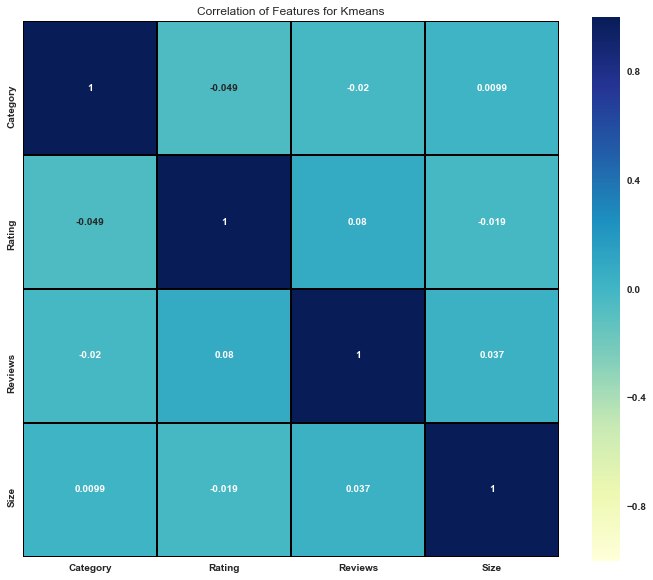

In [737]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Correlation of Features for Kmeans')
sb.heatmap(df_tr2.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
          cmap='YlGnBu', linecolor='black', annot=True)

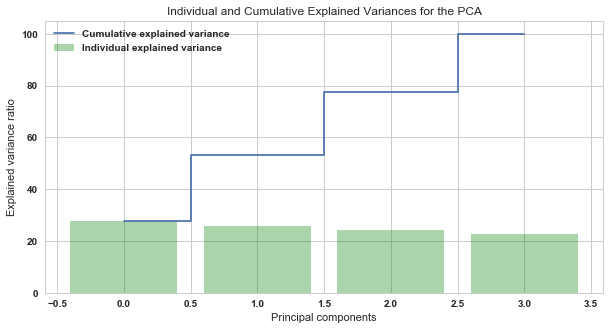

In [738]:
#Scale the features
X = df_tr2.values
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

#Calculating Eigenvectors and Eigenvalues of Covariance Matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

#Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse=True)

#Calculation of Explained Variance from the Eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] #Individual explained variance
cum_var_exp = np.cumsum(var_exp) #Cumulative explained variance

#Plot out the Explained Variances Superimposed
plt.figure(figsize=(10,5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Individual explained variance', color ='g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Individual and Cumulative Explained Variances for the PCA')
plt.show()

In [739]:
from sklearn.decomposition import PCA
pca3 = PCA(n_components=3)
x_3d = pca3.fit_transform(X_std)

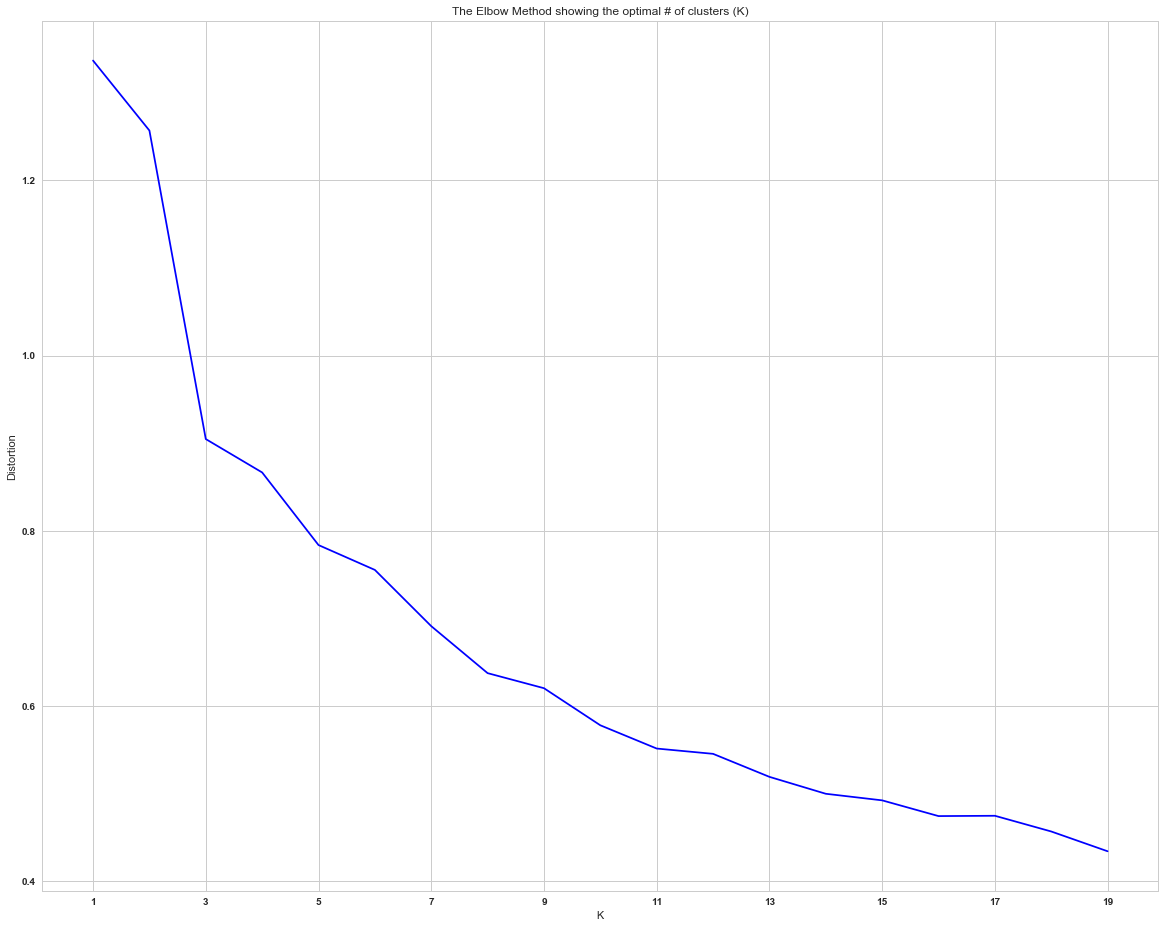

In [740]:
from scipy.spatial.distance import cdist

#To determine the # of clusters (k) via the elbow method
distortions = []
K=range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x_3d)
    kmeanModel.fit(x_3d)
    distortions.append(sum(np.min(cdist(x_3d, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x_3d.shape[0])
    
#Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.xticks(np.arange(min(K), max(K)+1, 2.0))
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal # of clusters (K)')
plt.show()

In [741]:
#Dump components relations with features:
data_scaled = pd.DataFrame(preprocessing.scale(df_tr2), columns = df_tr2.columns)
pca = PCA(n_components=3)
pca.fit_transform(data_scaled)
print(pd.DataFrame(pca.components_,columns=data_scaled.columns, index = ['PC-1', 'PC-2', 'PC-3']))

      Category    Rating   Reviews      Size
PC-1 -0.427030  0.664002  0.611458  0.053536
PC-2  0.374159 -0.171243  0.374513  0.830916
PC-3  0.805071  0.289269  0.285924 -0.431778


## Cluster Modeling

In [742]:
#Cluster the data
kmeans = KMeans(n_clusters=9, random_state=0).fit(df_tr2)
labels = kmeans.labels_

#glue back the cluster denotions to the original data
df_tr['clusters'] = labels
df_tr2['clusters'] = labels

#Columns we want to cluster on
cols = ['Category','Rating','Reviews','Size']

#Add the column into our list
cols.extend(['clusters'])

#let's analyze the clusters
print(df_tr2[cols].groupby(['clusters']).mean())

           Category    Rating       Reviews       Size
clusters                                              
0         16.554891  4.155447  3.362023e+04  36.525143
1         16.692308  4.500000  1.473277e+07  40.615385
2         15.507463  4.465672  5.224158e+06  54.043284
3         13.250000  4.600000  4.488970e+07  98.000000
4         14.000000  4.500000  2.772199e+07  76.000000
5         16.100000  4.425000  9.048122e+06  64.325000
6         15.810127  4.427848  3.003522e+06  49.656962
7         13.454545  4.472727  2.268395e+07  82.363636
8         17.132911  4.401899  9.484459e+05  41.827532


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## Output

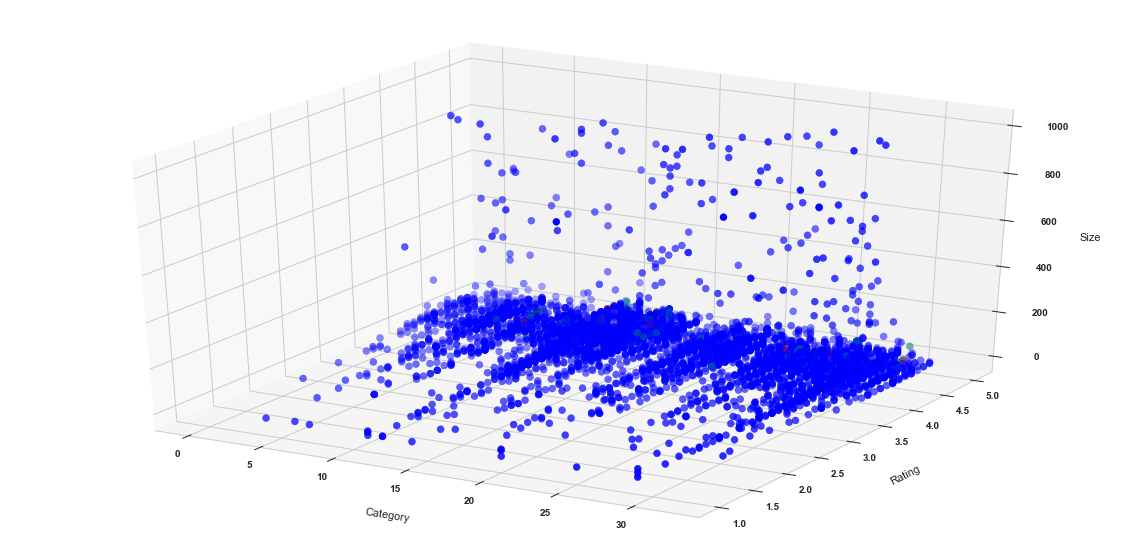

In [743]:
centers = np.array(kmeans.cluster_centers_)

#plot
colors = ['blue', 'green', 'red', 'orange', 'yellow', 'purple', 'pink', 'grey', 'teal']

fig = plt.figure(figsize=(20,10))

#Plot the Data Points
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df_tr2['Category'], df_tr2['Rating'], df_tr2['Size'], c=df_tr2['clusters'], cmap=matplotlib.colors.ListedColormap(colors), s=50)

#Plot the Plane to understand success
#yy, zz = np.meshgrid(range(49), range(799))
#xx = 200
#ax = plt.subplot(projection='3d')
#ax.plot_surface(xx,yy,zz)

#Plot the Centroids
#ax.scatter(centers[:,1], centers[:,0], centers[:,2],,
# s=500, c='black', marker='*', label='Centroid')

ax.tick_params(axis='z', which='major', pad=15)
ax.set_xlabel('Category', labelpad=24)
ax.set_ylabel('Rating', labelpad=22)
ax.set_zlabel('Size', labelpad=25)

font = {'family':'normal',
       'weight':'bold',
       'size':20}

plt.rc('font', **font)
plt.show()

In [744]:
def graphingScatterFnc(parameterOne,parameterTwo,parameterThree,parameterFour,parameterFive):
    sb.lmplot(parameterOne,parameterTwo,
             data=df_tr2,
             fit_reg=-False,
             hue=parameterThree,
             scatter_kws={'marker':'D',
                         's':50})

    plt.scatter(parameterFour,parameterFive, s=100, marker='*', color='black')

    font = {'family':'serif',
           'weight':'bold',
           'size':20}

    plt.rc('font', **font)

    plt.title(parameterOne+' vs '+parameterTwo)
    plt.xlabel(parameterOne)
    plt.ylabel(parameterTwo)

    Category   Ratings       Reviews       Size
0  16.554891  4.155447  3.362023e+04  36.525143
1  16.692308  4.500000  1.473277e+07  40.615385
2  15.507463  4.465672  5.224158e+06  54.043284
3  13.250000  4.600000  4.488970e+07  98.000000
4  14.000000  4.500000  2.772199e+07  76.000000
5  16.100000  4.425000  9.048122e+06  64.325000
6  15.810127  4.427848  3.003522e+06  49.656962
7  13.454545  4.472727  2.268395e+07  82.363636
8  17.132911  4.401899  9.484459e+05  41.827532


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


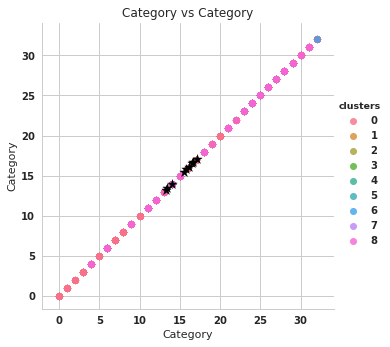

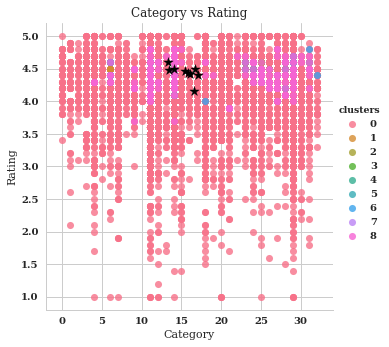

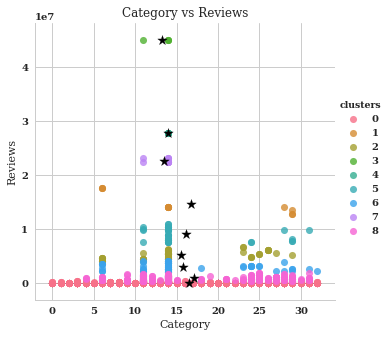

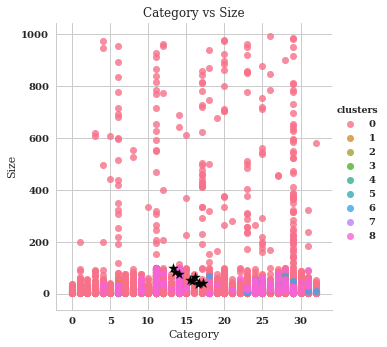

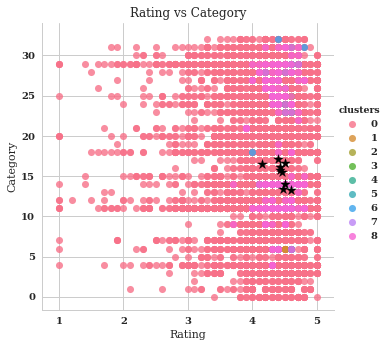

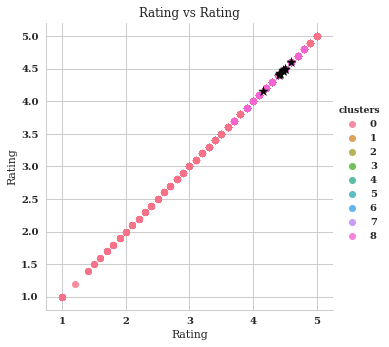

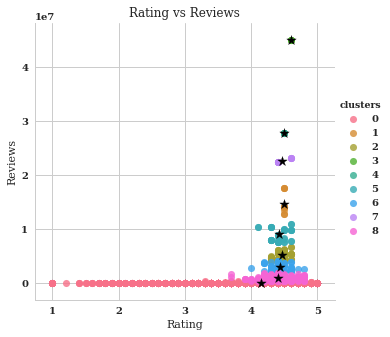

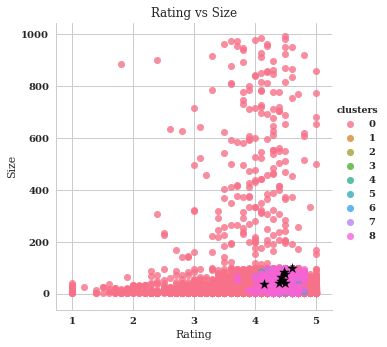

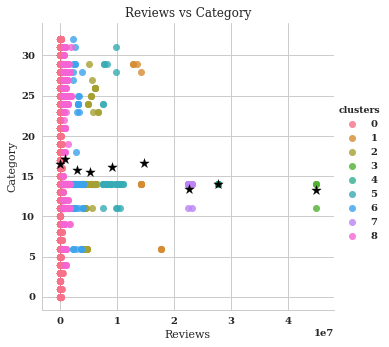

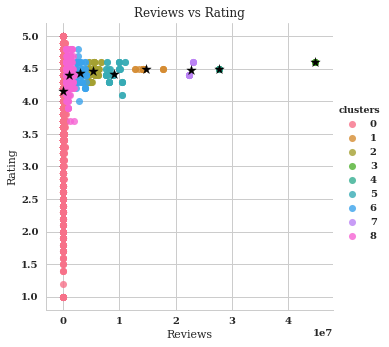

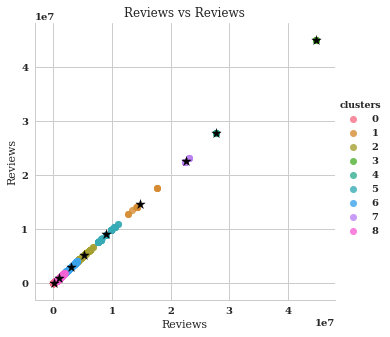

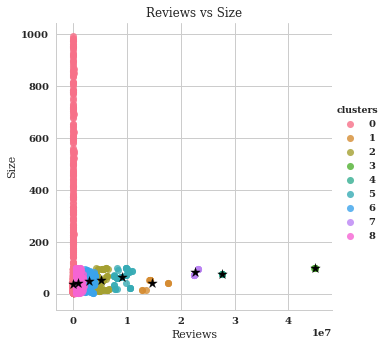

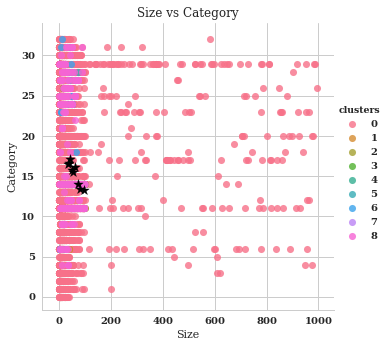

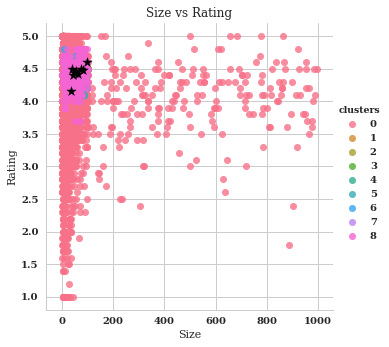

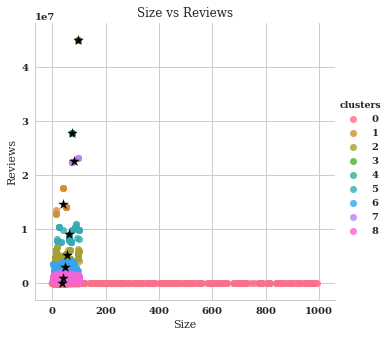

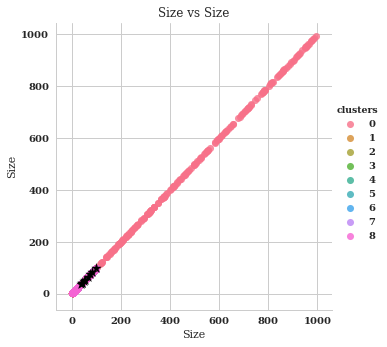

In [745]:
import itertools

lst = [0,1,2,3]
lst2 = [0,1,2,3]
c = list(itertools.product(lst,lst2))

centersDF = pd.DataFrame({'Category':centers[:,0],'Ratings':centers[:,1],'Reviews':centers[:,2],'Size':centers[:,3]})
print(centersDF)

i = 0
while i < len(c):
    for x in lst:
        graphingScatterFnc(clmns[c[i][0]],clmns[c[i][1]],'clusters',centersDF.iloc[:,c[i][0]],centersDF.iloc[:,c[i][1]])
        i+=1

In [746]:
#Get the indices of the points for each corresponding cluster
mydict = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

#Transform the dictionary into a list
dictlist = []
for key, value in mydict.items():
    temp = [key,value]
    dictlist.append(temp)

#Number of data points in each cluster
cnt = -1
clusterNumber = []
numberOfItemsCluster = []

for i in range(0,len(centers)-1):
    cnt += 1
    clusterNumber.append(cnt)
    numberOfItemsCluster.append(len(dictlist[i][1]))
    #print(len(dictlist[i][1]))

zippedTuple = zip(clusterNumber, numberOfItemsCluster)
    
#Cluster and the associated count of the data points in each cluster
for clusterNumber, numberOfItemsCluster in zippedTuple:
    print(clusterNumber, numberOfItemsCluster)

0 7187
1 13
2 67
3 4
4 6
5 40
6 79
7 11


In [747]:
for clusterNumberz in range(0,clusterNumber):
    df_temp = df_tr.loc[df_tr['clusters'] == clusterNumberz]
    df_temp2 = df_temp.groupby(['App','Category'])
    print("Cluster:", clusterNumberz)
    print(df_temp)

Cluster: 0
                                                     App  Category  Rating  \
0         Photo Editor & Candy Camera & Grid & ScrapBook         0     4.1   
1                                    Coloring book moana         0     3.9   
2      U Launcher Lite – FREE Live Cool Themes, Hide ...         0     4.7   
3                                  Sketch - Draw & Paint         0     4.5   
4                  Pixel Draw - Number Art Coloring Book         0     4.3   
5                             Paper flowers instructions         0     4.4   
6                Smoke Effect Photo Maker - Smoke Editor         0     3.8   
7                                       Infinite Painter         0     4.1   
8                                   Garden Coloring Book         0     4.4   
9                          Kids Paint Free - Drawing Fun         0     4.7   
10                               Text on Photo - Fonteee         0     4.4   
11               Name Art Photo Editor - Focus n Filt

In [748]:
groups = df_tr.groupby(by=['Category','App'])
print(groups.apply(lambda g: g[g['clusters'] == 0]))

                                                                                                                 App  \
Category App                                                                                                           
0        350 Diy Room Decor Ideas                           17                              350 Diy Room Decor Ideas   
         3D Color Pixel by Number - Sandbox Art Coloring    14       3D Color Pixel by Number - Sandbox Art Coloring   
         AJ Styles HD Wallpapers                            5254                             AJ Styles HD Wallpapers   
         AJ Styles Wallpaper 2018 - AJ Styles HD Wallpaper  5258   AJ Styles Wallpaper 2018 - AJ Styles HD Wallpaper   
         Ai illustrator viewer                              5179                               Ai illustrator viewer   
         Animated Photo Editor                              27                                 Animated Photo Editor   
         Anime Manga Coloring Book      

## Conclusion

## Next Steps

bafsdaf